In [35]:
# This notebook is to illustrate a custom loss function which can be used to solve differential equations.

# Additional guidance can be found on tensorflow's website:
# - Customisation with gradients
# - Writing your custom training loop

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model

In [37]:
# Before we get started, let's use a standard ODE solver for our problem

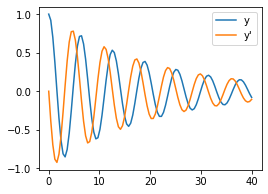

In [38]:
from scipy.integrate import odeint
from matplotlib import pyplot as plt


# vanilla scipy ode solver
# u''(x) + a u'(x) + b u(x)=0
a=0.1
b=1.

def calc_deri(yvec, time, a, b):
    return (yvec[1], -a * yvec[1] - b * yvec[0])

time_vec = np.linspace(0, 40, 100)
yinit = (1, 0) # boundary condition
yarr = odeint(calc_deri, yinit, time_vec, args=(a,b))

plt.figure(figsize=(4, 3))
plt.plot(time_vec, yarr[:, 0], label='y')
plt.plot(time_vec, yarr[:, 1], label="y'")
plt.legend(loc='best')
plt.show()

In [39]:
# this code requires tensorflow 2
tf.__version__

'2.3.0'

In [40]:
# let's list what we want to have:

# we want to have a neural network which parametrises the solution u(x)
# for the differential equation u''(x) + a u'(x) + b u(x)=0

# for sampling points we want to use new points for each epoch to avoid overfitting

In [41]:
a = tf.constant(1.,dtype="float64")
b = tf.constant(10.,dtype="float64")

# our Neural network model

tf.keras.backend.set_floatx('float64')

inp = Input(shape=(1,))
x = Dense(100,activation='tanh')(inp)
x = Dense(100,activation='tanh')(x)
out = Dense(1)(x)

model = Model(inputs=inp,outputs=out)
model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense_6 (Dense)              (None, 100)               200       
_________________________________________________________________
dense_7 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 101       
Total params: 10,401
Trainable params: 10,401
Non-trainable params: 0
_________________________________________________________________


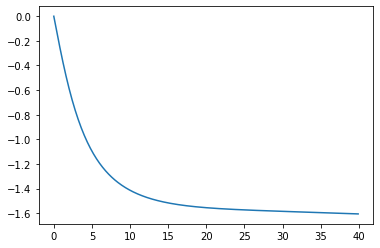

In [42]:
# Our model at initialisation:
# random guess
preds = model.predict(np.arange(0,40,0.1))
plt.plot(np.arange(0,40,0.1),preds)

In [43]:
# let's get some basics in first
x=tf.Variable(3.0)
with tf.GradientTape() as tape:
    y = x**2
dy_dx = tape.gradient(y,x)

In [44]:

print(dy_dx.numpy())

6.0


In [45]:
# Realising a second derivative

x=tf.Variable(1.0)
with tf.GradientTape() as t2:
    with tf.GradientTape() as t1:
        y = x**3
    dy_dx=t1.gradient(y,x)
d2y_dx=t2.gradient(dy_dx,x)

print(dy_dx.numpy())
print(d2y_dx.numpy())

3.0
6.0


In [46]:
# Let's look at the individual building blocks:

u = model
train_data=np.random.uniform(0,40,size=(200,1)) #let's take 20 datapoints
x = tf.Variable(train_data)

with tf.GradientTape() as t3:
    with tf.GradientTape() as t2:
        with tf.GradientTape() as t1:
            u = model(x,training=True)
        du_dx=t1.gradient(u,x)
    d2u_dx=t2.gradient(du_dx,x)
    loss = (d2u_dx + a*du_dx + b*u)**2

print(loss.numpy())

[[1.28004770e+02]
 [2.42792344e+02]
 [8.78299670e+00]
 [2.40909580e+02]
 [2.50869850e+02]
 [7.55690515e+01]
 [2.50282542e+02]
 [2.27275183e+02]
 [2.16465197e+02]
 [2.54112108e+02]
 [6.24563682e+01]
 [2.56853118e+02]
 [2.50974559e+02]
 [2.53540303e+02]
 [2.51122467e+02]
 [2.41067237e+02]
 [2.53543938e+02]
 [2.48288489e+02]
 [2.09789160e+01]
 [7.46886761e+01]
 [2.53895122e+02]
 [1.82799823e+02]
 [2.52729651e+02]
 [1.72099861e+01]
 [3.02634917e+01]
 [1.74326793e+02]
 [2.80223415e-01]
 [1.69124108e+02]
 [1.36861606e+01]
 [1.45184109e+02]
 [2.33689945e+02]
 [2.42568656e+02]
 [5.38720020e+00]
 [1.36134174e+02]
 [1.38914971e+02]
 [2.51934882e+02]
 [2.43886927e+02]
 [2.40374191e+02]
 [2.50237140e+02]
 [2.57305323e+02]
 [2.49828285e+02]
 [2.07148877e+02]
 [2.43727872e+02]
 [8.04034800e+01]
 [2.45567758e+02]
 [1.49321556e+02]
 [2.49615438e+02]
 [2.42051349e+02]
 [8.94477745e+01]
 [2.16851413e+02]
 [1.00868894e+02]
 [1.46507650e+01]
 [1.18022339e+01]
 [2.30725413e+02]
 [2.52262920e+02]
 [8.752809

In [47]:
# Let's add boundary conditions as additional loss terms

bu0 = tf.constant(1.,dtype='float64')
bdu0_dx = tf.constant(0.,dtype='float64')
#loss2 = (u(x0) - u0)**2 + (du_dx(x0) - du0_dx)**2

#u = model
train_data=np.random.uniform(0,40,size=(20,1))
x = tf.Variable(train_data)
print(x.shape) # 20,1
x0 = tf.Variable(np.zeros(shape=(20,1)))

with tf.GradientTape() as t3:
    with tf.GradientTape() as t2:
        with tf.GradientTape() as t1:
            u = model(x,training=True)
        with tf.GradientTape() as t0:
            u0 = model(x0,training=True)
        du_dx=t1.gradient(u,x)
        du0_dx=t0.gradient(u0,x0)
    d2u_dx=t2.gradient(du_dx,x)
    #eqn = (d2u_dx+a*du_dx+b*u)
    loss2 = (u0-bu0)**2+(du0_dx-bdu0_dx)**2
    loss = (d2u_dx+a*du_dx+b*u)**2+loss2
    
#loss2
#du0_dx
#loss2.numpy()
loss.numpy()

(20, 1)


array([[247.41487308],
       [233.27057598],
       [187.98465447],
       [214.99197566],
       [253.15825208],
       [236.72950107],
       [238.49389345],
       [248.34011602],
       [ 79.38032515],
       [255.8921963 ],
       [252.39484833],
       [ 37.43507796],
       [239.7663065 ],
       [188.85086495],
       [239.38180232],
       [129.49971232],
       [253.23745237],
       [246.46844173],
       [243.17384566],
       [114.57913268]])

In [48]:
optimizer = tf.keras.optimizers.Adam(1e-4)

#@tf.function
def train_step(samples,verbose=True,alpha=1.):
    bu0= tf.constant(1.,dtype='float64')
    bdu0_dx=tf.constant(0.,dtype='float64')
    alpha_b=tf.constant(alpha,dtype='float64')
    
    train_data = np.random.uniform(0,40,size=(samples,1))
    x = tf.Variable(train_data)
    x0 = tf.Variable(np.zeros(shape=(samples,1)))
    with tf.GradientTape() as t3:
        with tf.GradientTape() as t2:
            with tf.GradientTape() as t1:
                u = model(x,training=True)
            with tf.GradientTape() as t0:
                u0 = model(x0,training=True)
            du_dx=t1.gradient(u,x)
            du0_dx=t0.gradient(u0,x0)
        d2u_dx=t2.gradient(du_dx,x)
        loss2 = (u0-bu0)**2+(du0_dx-bdu0_dx)**2
        loss = (d2u_dx+a*du_dx+b*u)**2+alpha*loss2
    gradients_of_nn = t3.gradient(loss,model.trainable_variables)
    optimizer.apply_gradients(zip(gradients_of_nn, model.trainable_variables))
    if verbose==True:
        print(np.mean(loss))

In [49]:
#for debugging:

bu0= tf.constant(1.,dtype='float64')
bdu0_dx=tf.constant(0.,dtype='float64')
    
train_data=np.random.uniform(0,40,size=(20,1))
x = tf.Variable(train_data)
x0 = tf.Variable(np.zeros(shape=(20,1)))
with tf.GradientTape() as t3:
    with tf.GradientTape() as t2:
        with tf.GradientTape() as t1:
            u = model(x,training=True)
        with tf.GradientTape() as t0:
            u0 = model(x0,training=True)
        du_dx=t1.gradient(u,x)
        du0_dx=t0.gradient(u0,x0)
    d2u_dx=t2.gradient(du_dx,x)
        #eqn = (d2u_dx+a*du_dx+b*u)
    loss2 = (u0-bu0)**2+(du0_dx-bdu0_dx)**2
    loss = (d2u_dx+a*du_dx+b*u)**2+loss2
gradients_of_nn = t3.gradient(loss,model.trainable_variables)
optimizer.apply_gradients(zip(gradients_of_nn, model.trainable_variables))

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1>

In [50]:
train_step(300,verbose=False)

ValueError: in user code:

    <ipython-input-48-dc57a8db4949>:10 train_step  *
        x = tf.Variable(train_data)
    C:\ProgramData\Miniconda3\envs\MLinPhysics38\lib\site-packages\tensorflow\python\ops\variables.py:262 __call__  **
        return cls._variable_v2_call(*args, **kwargs)
    C:\ProgramData\Miniconda3\envs\MLinPhysics38\lib\site-packages\tensorflow\python\ops\variables.py:244 _variable_v2_call
        return previous_getter(
    C:\ProgramData\Miniconda3\envs\MLinPhysics38\lib\site-packages\tensorflow\python\ops\variables.py:67 getter
        return captured_getter(captured_previous, **kwargs)
    C:\ProgramData\Miniconda3\envs\MLinPhysics38\lib\site-packages\tensorflow\python\eager\def_function.py:701 invalid_creator_scope
        raise ValueError(

    ValueError: tf.function-decorated function tried to create variables on non-first call.


In [ ]:
def train(epochs,print_every=100,alpha=1):
    for epoch in range(epochs):
        if epoch%print_every==0:
            print('Loss at epoch: '+str(epoch))
            train_step(300,verbose=True,alpha=alpha)
        else:
            train_step(300,verbose=False,alpha=alpha)

In [ ]:
train(400)

In [ ]:
preds=model.predict(np.arange(0,40,0.1))
plt.plot(np.arange(0,40,0.1),preds)

In [ ]:
# training with different relative weight
train(4000,alpha=0.1)

In [ ]:
preds=model.predict(np.arange(0,40,0.1))
plt.plot(np.arange(0,40,0.1),preds)